#The purpose of this notebook is to look into genes within Synechococcus WH7803 that could potentially be targeted by phage-encoded tRNAs.

>I chose this host because there's a large group of phage genomes available through NCBI isolated on this host, and it seems to be one of the main Synechococcus strains used.

In [1]:
Hosts=["Synechococcus"]
syn_accs=[]
phage_info=open("./data/top_host_phage_info.txt")
for line in phage_info.readlines():
    host=line.split("\t")[0]
    trna_count=line.split("\t")[-3]
    name=line.split("\t")[3]
    if host in Hosts:
        syn_accs.append(line.split("\t")[2])

In [2]:
import os
from Bio import SeqIO
import subprocess

#grab phages that have Syn7803 as the host of isolation

s7803p=[]    #vector of accession numbers for phages of Synechococcus strain 7803

for phage in syn_accs:
    gbk_file="./data/pgenomes/"+phage+".gbk"
    if os.path.exists(gbk_file):
        handle=SeqIO.parse(gbk_file, "genbank")
        for g in handle:
            for feature in g.features:
                if feature.type=="source":
                    if "host" in feature.qualifiers.keys():
                        hostish=(feature.qualifiers["host"][0])
                    elif "lab_host" in feature.qualifiers.keys():
                        hostish=(feature.qualifiers["lab_host"][0]+"***")
                    elif "isolate" in feature.qualifiers.keys():
                        hostish=(feature.qualifiers["isolate"][0])
                        #print(feature.qualifiers)
                    else:
                        hostish="none"
                        #print("no host specified for "+phage)
                        #print(feature.qualifiers)
        
        if "7803" in hostish:
            s7803p.append(phage)
    else:
        print("no gbk file for "+phage)

print(len(s7803p))

no gbk file for KC310805.1
no gbk file for NC_025456.1
no gbk file for NC_020838.1
no gbk file for HM480106.1
no gbk file for NC_020867.1
no gbk file for NC_025464.1
149


In [3]:
from Bio import SeqIO
import subprocess
import os

## now extract all CDS from genbank file:
def gbk_to_cds_fasta(gbk, output):
    handle=SeqIO.parse(gbk,"genbank")
    output=open(output,"w")
    count=0
    for g in handle:
        for feature in g.features:
            if feature.type=="CDS":
                count=count+1
                if "locus_tag" in feature.qualifiers.keys():
                    feature_name=feature.qualifiers["locus_tag"]
                elif "gene" in feature.qualifiers.keys(): 
                    feature_name=feature.qualifiers["gene"]
                else:
                    feature_name=feature.qualifiers["product"]
                feature_seq=feature.extract(g.seq)
                output.write(">"+str(feature_name)+"\n"+str(feature_seq)+"\n")
    print(str(count)+ " CDS sequences extracted from "+gbk)
    output.close()

def gbk_to_fasta(gbk, output):
    SeqIO.convert(gbk,"gb",output,"fasta")
    
def run_codonM(fasta, output):
    subprocess.call(["perl","./scripts/codonR/codonM",fasta,output])
    
def run_trna_scan(input_file, output):
    args=["tRNAscan-SE", "-o", output, "-G", "-D","-N", input_file]
    subprocess.call(args)
    print("tRNA scan of "+input_file+" is done!")

In [ ]:
os.mkdir("./data/pgenomes/Syn7803phages")
path="./data/pgenomes/Syn7803phages/"

for i in s7803p:
    gbk="./data/pgenomes/"+i+".gbk"
    fasta=path+i+".fasta"
    cds_fasta=path+i+".cds.fasta"
    trna=path+i+".trna"
    gbk_to_cds_fasta(gbk,cds_fasta)
    gbk_to_fasta(gbk, fasta)
    run_trna_scan(fasta, trna)

In [3]:
%load_ext rpy2.ipython
%R library(dplyr); library(magrittr); library(ggplot2); library(reshape)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename



First looking into how phage-encoded tRNAs influence the tRNA adaptation index (tAI) of host genes (tAI described in dos Reis et al, 2004).  Using perl and R scripts from that paper as well as my own set of functions wrapped around the scripts as needed.

In [4]:
%%R
##Functions:

source("./scripts/codonR/tAI.R")

#need file: "./data/codon_list.txt"
#must create codonm files using codonm.pl and .trna files using tRNAscanSE for phages and for the host
#must have host genome as a fasta file of cds sequences


tscan_to_list<-function (tscanfile, codon_list="./data/codon_list.txt"){
    codons=read.table(codon_list, header=FALSE)
    trnas=read.table(tscanfile, sep="\t", skip=3, header=FALSE)%>%group_by(V6)%>%summarise(count=n())
    codons$count<-trnas$count[match(codons$V2, trnas$V6)]
    codons[is.na(codons)]<-0
    return(codons$count)
    }

ph_tscan_to_list<-function(host_tscan, phage_tscan, codon_list="./data/codon_list.txt"){
    codons=read.table(codon_list)
    h=read.table(host_tscan, sep="\t", skip=3, header=FALSE)%>%group_by(V6)%>%summarise(count=n())
    p=read.table(phage_tscan, sep="\t", skip=3, header=FALSE)%>%group_by(V6)%>%summarise(count=n())
    codons$h<-h$count[match(codons$V2, h$V6)]
    codons$p<-p$count[match(codons$V2, p$V6)]
    codons[is.na(codons)]<-0
    codons<-mutate(codons, count=h+p)
    return(codons$count)
}

calculate_ph_tais<-function(htrna, ptrna, codonM_file){
    h.trna<-tscan_to_list(htrna)
    ph.trna<-ph_tscan_to_list(htrna, ptrna)
    
    h.ws<-get.ws(tRNA=h.trna, sking=1)
    ph.ws<-get.ws(tRNA=ph.trna, sking=1)
    
    
    h.m<-matrix(scan(codonM_file),ncol=61, byrow=T)
    h.m<-h.m[,-33]
    
    h.tai<-get.tai(h.m, h.ws)
    ph.tai<-get.tai(h.m, ph.ws)
    
    return(cbind.data.frame(h.tai, ph.tai))
}

calculate_ph_tai<-function(htrna, ptrna, codonM_file){
    h.trna<-tscan_to_list(htrna)
    ph.trna<-ph_tscan_to_list(htrna, ptrna)
    h.ws<-get.ws(tRNA=h.trna, sking=1)
    ph.ws<-get.ws(tRNA=ph.trna, sking=1)
    h.m<-matrix(scan(codonM_file),ncol=61, byrow=T)
    h.m<-h.m[,-33]
    ph.tai<-get.tai(h.m, ph.ws)
    
    return(ph.tai)
}

calculate_tai<-function(trna, codonM_file){
    h.trna<-tscan_to_list(trna)
    h.ws<-get.ws(tRNA=h.trna, sking=1)
    print("scanning codonM file")
    h.m<-matrix(scan(codonM_file),ncol=61, byrow=T)
    h.m<-h.m[,-33]
    h.tai<-get.tai(h.m, h.ws)
    return(h.tai)
}

#modified from dos Reis... not used in below calculations.
get.ws.phage <- function(tRNA,   # tRNA gene copy number
                         h.ws,   # host ws after sending host tRNA list through get.ws
                   s = ops,      # selective constraints determined by dos Reis 2004
                   sking) # super kingdom: 0-eukaryota, 1-prokaryota
{

  p = 1 - s

  # initialise w vector
  W = NULL  # don't confuse w (lowercase) and W (uppercase)

  # obtain absolute adaptiveness values (Ws)
  for (i in seq(1, 61, by=4))
    W = c(W,
      p[1]*tRNA[i]   + p[5]*tRNA[i+1],     # INN -> NNT, NNC, NNA
      p[2]*tRNA[i+1] + p[6]*tRNA[i],       # GNN -> NNT, NNC
      p[3]*tRNA[i+2] + p[7]*tRNA[i],       # TNN -> NNA, NNG
      p[4]*tRNA[i+3] + p[8]*tRNA[i+2])     # CNN -> NNG

  # check methionine
  W[36] = p[4]*tRNA[36]
  
  # if bacteria, modify isoleucine ATA codon
  if(sking == 1) W[35] = p[9]

  # get rid of stop codons (11, 12, 15) and methionine (36)
  W = W[-c(11,12,15,36)]

  # get ws
  w = W/max(W)

  if(sum(w == 0) > 0) {
    #ws <- w[w != 0] # zero-less ws
    hgm <- exp(sum(log(h.ws))/length(h.ws)) # geometric mean of host codon ws
    w[w == 0] = hgm # for phage which may not have complete set of tRNAs, take geometric mean of host ws
  }

  return(w)
}
      
calculate_phage_trna_tai<-function(ptrna, htrna, codonM_file){
    h.trna<-tscan_to_list(htrna)
    p.trna<-tscan_to_list(ptrna)
    host.ws<-get.ws(tRNA=h.trna, sking=1)
    p.ws<-get.ws.phage(tRNA=p.trna, h.ws=host.ws, sking=1)
    print("scanning codonM file")
    h.m<-matrix(scan(codonM_file),ncol=61, byrow=T)
    h.m<-h.m[,-33]
    p.tai<-get.tai(h.m, p.ws)
    return(p.tai)
}

In [5]:
%%R -i s7803p
###Look through tRNA content and select phages with unique tRNA profiles

codons<-read.table("./data/codon_list.txt", header=FALSE)
colnames(codons)[2]<-"V6"

for (phage in s7803p){
    trna<-read.table(paste("./data/pgenomes/Syn7803phages/", phage, ".trna",sep=""), skip=3, header=FALSE,sep="\t")
    trna%>%group_by(V6)%>%summarise(count=n())->trna
    colnames(trna)[2]<-phage
    codons<-merge(codons, trna, by="V6", all.x=TRUE, all.y=TRUE)
}


codons$V1<-NULL
codons[is.na(codons)]<-0
rownames(codons)<-codons$V6
codons$V6<-NULL

members<-t(as.matrix(codons))
unique_trnas<-rownames(unique(members))
unique_trna_profiles<-unique(members)
print(nrow(members))
print(nrow(unique(members)))
print(data.frame(unique_trna_profiles))
print(data.frame(rowSums(unique_trna_profiles)))

[1] 149
[1] 13
            AAA AAC AAG AAT ACA ACC ACG ACT AGA AGC AGG AGT ATA ATC ATG ATT CAA
KJ019129.1    0   1   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
NC_027132.1   0   1   0   0   1   0   0   0   1   0   0   0   0   0   1   0   0
KJ019065.1    0   1   0   0   1   0   0   0   1   0   0   0   0   0   0   0   0
KJ019045.1    0   1   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
NC_023587.1   0   1   0   0   1   0   0   0   1   0   0   0   0   0   0   0   0
KF156339.1    0   1   0   0   1   0   0   0   1   0   0   0   0   0   0   0   0
HQ317291.1    0   1   0   0   1   0   0   0   1   0   0   0   0   0   0   0   0
NC_026926.1   0   1   0   0   1   0   0   0   1   0   0   0   0   0   1   0   0
NC_020851.1   1   1   0   0   1   0   0   0   1   1   0   0   0   1   0   0   0
NC_020486.1   0   1   0   0   1   0   0   0   1   0   0   0   0   0   0   0   0
NC_020837.1   0   1   0   0   1   0   0   0   1   0   0   0   0   0   0   0   0
NC_006820.1   1   1   0  

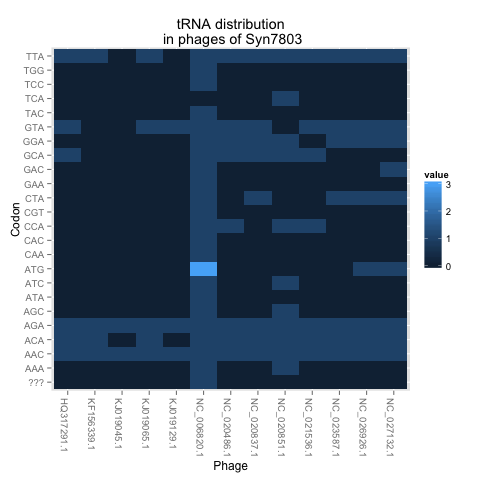

In [6]:
%%R
t(unique_trna_profiles[,which(colSums(unique_trna_profiles)>0)])%>%.[,order(colSums(.))]->trnas2
trnas2%>%melt%>%ggplot(aes(X2, X1))+geom_tile(aes(fill=value))+theme(axis.text.x=element_text(angle = -90, hjust = 0))->fig
fig+labs(title="tRNA distribution\n in phages of Syn7803", x="Phage",y="Codon")

###So above shows that of the 149 phages in the dataset that infect Syn 7803, there are 13 unique tRNA patterns.
>####I will proced by looking into how these unique sets of tRNAs changes the tRNA Adaption Index of host genes

[1] "scanning codonM file"
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items


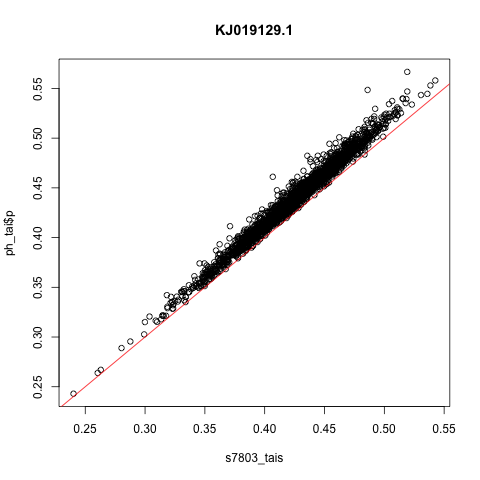

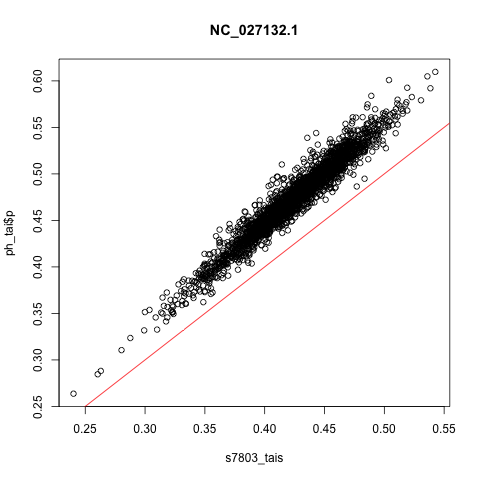

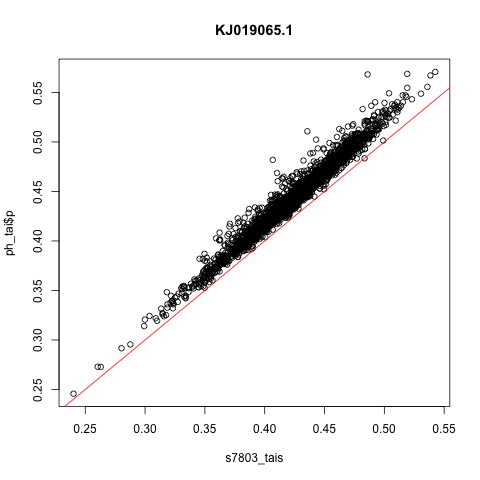

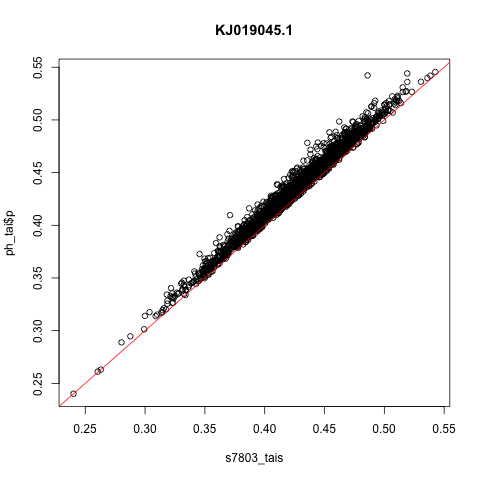

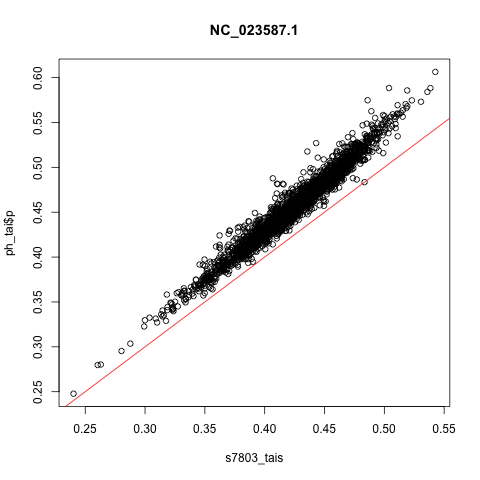

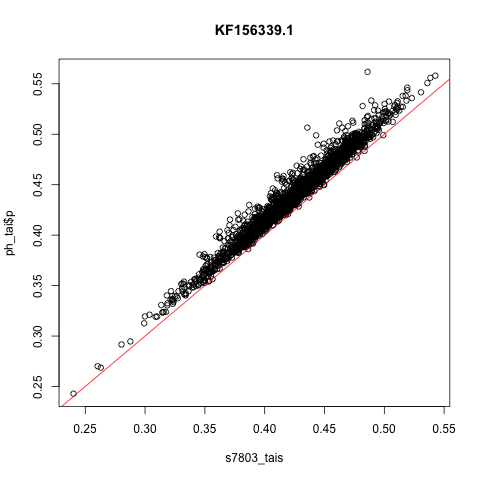

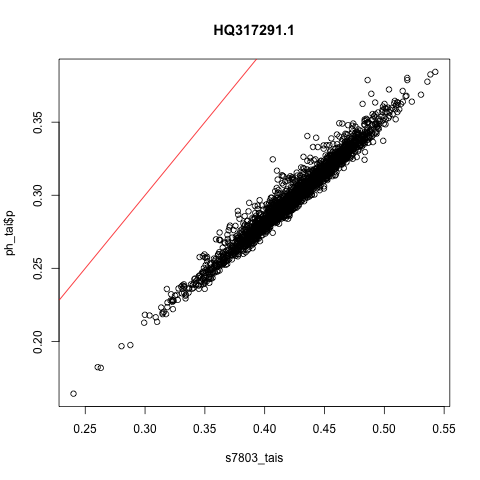

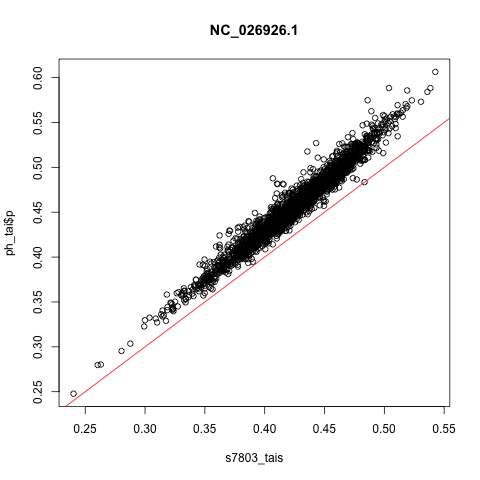

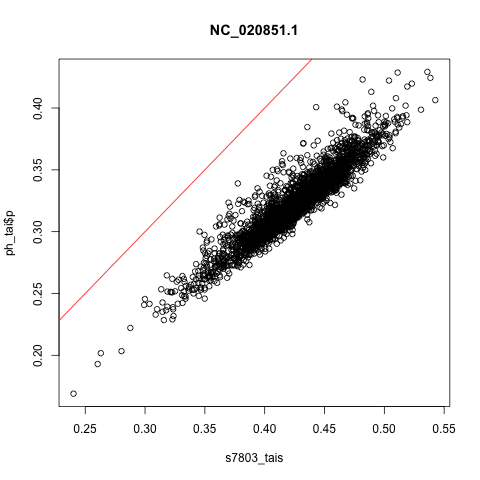

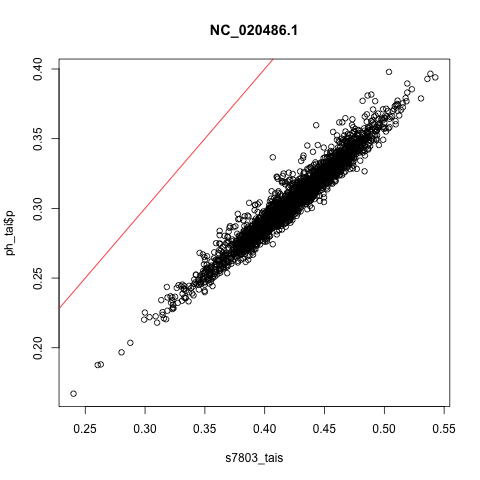

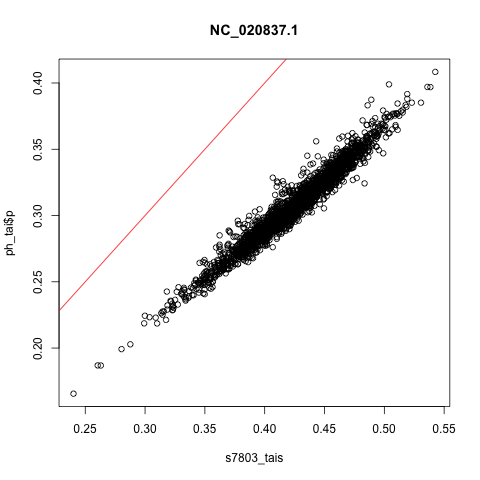

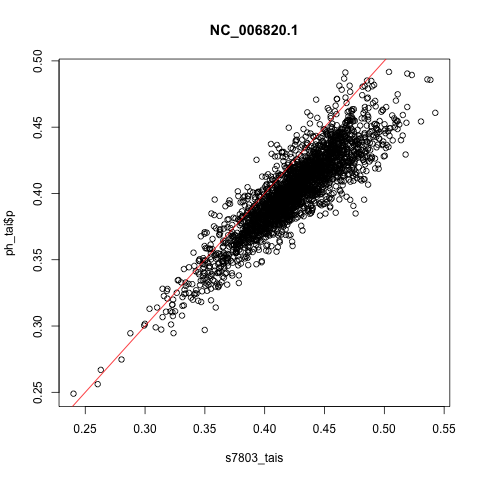

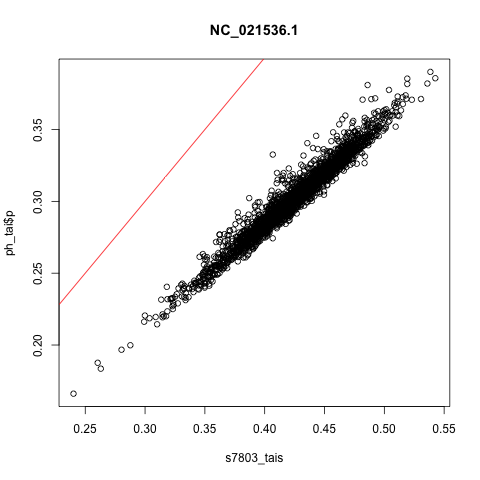

In [7]:
%%R -i s7803p

#look at changes in tAI values for different genes based on combining phage and host tRNA content:
#plot out shift in tAI of host genes based on host-supplied tRNAs, and then combined phage and host tRNAs

library(dplyr)

s7803_tais<-calculate_tai("./data/svm1/Syn7803.trna", "./data/svm1/Syn7803.cds.m")
tai_change<-vector(length=length(s7803_tais))

for (i in unique_trnas){
    ptrna<-paste("./data/pgenomes/Syn7803phages/",i,".trna",sep="")
    htrna<-"./data/svm1/Syn7803.trna"
    codonm<-"./data/svm1/Syn7803.cds.m"
    p<-calculate_ph_tai(ptrna, htrna, codonm)
    ph_tai<-cbind.data.frame(s7803_tais, p)
    ph_tai<-mutate(ph_tai, fold_change=s7803_tais-p)
    tai_change<-cbind.data.frame(tai_change, ph_tai$fold_change)
    colnames(tai_change)[ncol(tai_change)]<-i
    plot(s7803_tais, ph_tai$p, main=i)
    abline(0,1,col="red")
}

'data.frame':	2533 obs. of  6 variables:
 $ title: Factor w/ 2533 levels "SynWH7803_0001           ",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Nc   : num  43.6 49.5 45.8 45.4 43.5 ...
 $ GC3s : num  0.7 0.631 0.675 0.7 0.709 0.679 0.682 0.692 0.655 0.655 ...
 $ GC   : num  0.615 0.633 0.64 0.601 0.627 0.614 0.644 0.601 0.569 0.592 ...
 $ L_aa : int  389 249 765 488 821 298 320 219 256 210 ...
 $ X    : logi  NA NA NA NA NA NA ...


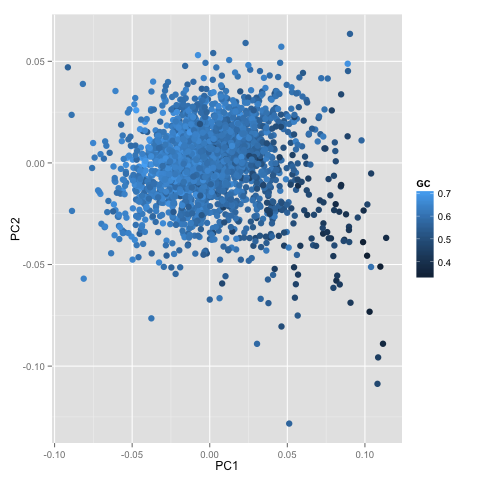

In [119]:
%%R
#plot PCA analysis of host gene responses to different tAI shifts:

library(ggfortify)

syn_w<-read.table("./data/svm1/Syn7803.w", header=TRUE, sep="\t", na.strings="*****")
head(syn_w)
rownames(syn_w)<-syn_w$title
rownames(tai_change)<-syn_w$title
tai_change$tai_change<-NULL
str(syn_w)


tai_change$tai_change<-NULL
autoplot(prcomp(tai_change), labels=TRUE, size=3, data=syn_w, col="GC")

In [15]:
%%R
summary(prcomp(tai_change))

Importance of components:
                           PC1     PC2     PC3      PC4      PC5     PC6
Standard deviation     0.02862 0.01894 0.01249 0.006933 0.005889 0.00473
Proportion of Variance 0.56298 0.24643 0.10716 0.033040 0.023830 0.01538
Cumulative Proportion  0.56298 0.80942 0.91657 0.949610 0.973440 0.98882
                            PC7     PC8      PC9      PC10      PC11      PC12
Standard deviation     0.002789 0.00208 0.001877 0.0008013 2.747e-05 1.258e-05
Proportion of Variance 0.005350 0.00297 0.002420 0.0004400 0.000e+00 0.000e+00
Cumulative Proportion  0.994160 0.99714 0.999560 1.0000000 1.000e+00 1.000e+00
                            PC13
Standard deviation     6.803e-18
Proportion of Variance 0.000e+00
Cumulative Proportion  1.000e+00


###Now comparing residuals of linear model comparing host tRNA adaptation versus phage+host tRNA adaptation instead of fold change 

In [96]:
%%R -i s7803p

library(dplyr)

s7803_tais<-calculate_tai("./data/svm1/Syn7803.trna", "./data/svm1/Syn7803.cds.m")
tai_resid<-vector(length=length(s7803_tais))

for (i in unique_trnas){
    ptrna<-paste("./data/pgenomes/Syn7803phages/",i,".trna",sep="")
    htrna<-"./data/svm1/Syn7803.trna"
    codonm<-"./data/svm1/Syn7803.cds.m"
    p<-calculate_ph_tai(ptrna, htrna, codonm)
    linmod<-lm(p~s7803_tais)
    resids<-resid(linmod)
    tai_profiles<-
    tai_resid<-cbind.data.frame(tai_resid, resids)
    colnames(tai_resid)[ncol(tai_resid)]<-i
}

[1] "scanning codonM file"
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 154513 items


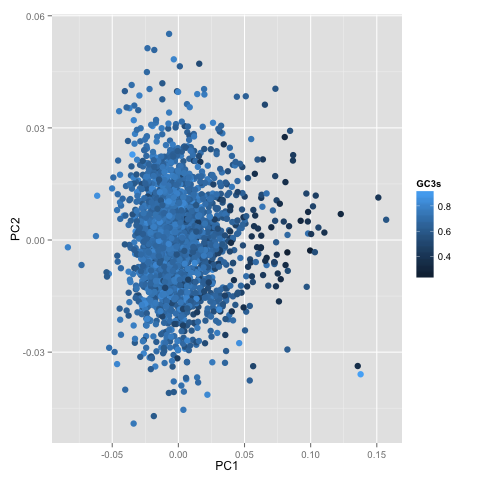

In [98]:
%%R
library(ggfortify)
syn_w<-read.table("./data/svm1/Syn7803.w", header=TRUE, sep="\t", na.strings="*****")
rownames(syn_w)<-syn_w$title
rownames(tai_resid)<-syn_w$title
tai_resid$tai_resid<-NULL

tai_resid$tai_resid<-NULL
tr_pca<-prcomp(tai_resid)
autoplot(tr_pca, labels=TRUE, size=3, data=syn_w, col="GC3s")

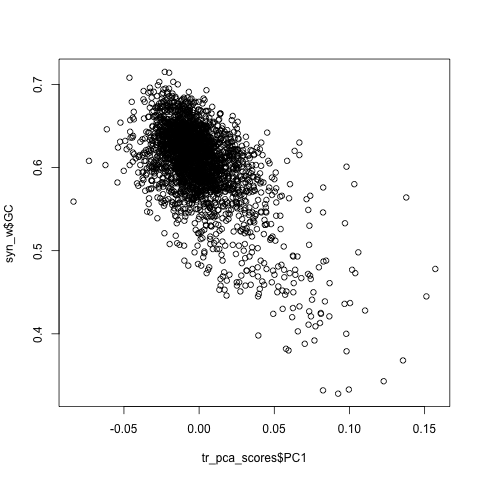

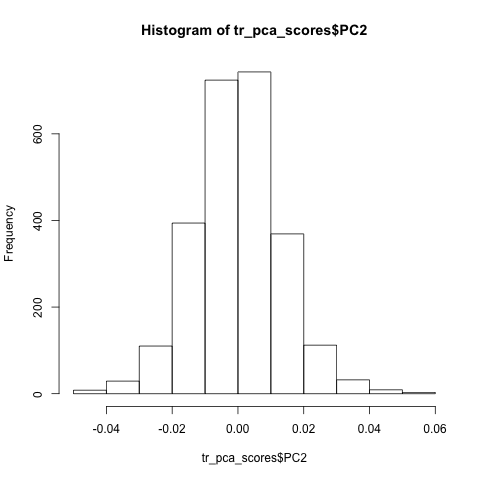

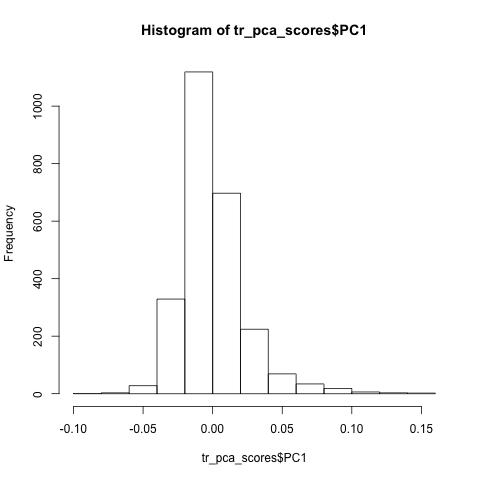

In [141]:
%%R
tr_pca_scores<-tr_pca$x%>%data.frame
tr_pca_scores$title<-rownames(tr_pca_scores)
tr_pca_scores$title<-gsub(" ","",tr_pca_scores$title)
plot(tr_pca_scores$PC1, syn_w$GC, type="p")
annotations<-read.csv("Syn7803_CDS_table.txt", sep="\t",header=TRUE)
tr_pca_scores<-merge(tr_pca_scores, annotations, by="title")
hist(tr_pca_scores$PC2)
hist(tr_pca_scores$PC1)

Relationship between GC concent and PC1 seen above.  Identities of genes with a PCA1 score greater than 0.07 seen below.

In [117]:
%%R
tr_pca_scores[which(tr_pca_scores$PC1>0.07),c(1,15)]

              title
90   SynWH7803_0090
91   SynWH7803_0091
92   SynWH7803_0092
93   SynWH7803_0093
94   SynWH7803_0094
95   SynWH7803_0095
96   SynWH7803_0096
97   SynWH7803_0097
247  SynWH7803_0247
500  SynWH7803_0500
538  SynWH7803_0538
555  SynWH7803_0555
556  SynWH7803_0556
557  SynWH7803_0557
874  SynWH7803_0874
902  SynWH7803_0902
909  SynWH7803_0909
910  SynWH7803_0910
933  SynWH7803_0933
993  SynWH7803_0993
1013 SynWH7803_1013
1078 SynWH7803_1078
1183 SynWH7803_1183
1232 SynWH7803_1232
1233 SynWH7803_1233
1302 SynWH7803_1302
1324 SynWH7803_1324
1331 SynWH7803_1331
1443 SynWH7803_1443
1672 SynWH7803_1672
1702 SynWH7803_1702
1795 SynWH7803_1795
1796 SynWH7803_1796
1797 SynWH7803_1797
1798 SynWH7803_1798
1799 SynWH7803_1799
1800 SynWH7803_1800
1940 SynWH7803_1940
2105 SynWH7803_2105
2110 SynWH7803_2110
2111 SynWH7803_2111
2112 SynWH7803_2112
2116 SynWH7803_2116
2117 SynWH7803_2117
2118 SynWH7803_2118
2392 SynWH7803_2392
                                                            

###Take aways:

Multivariate approach to assessing host genes targeted by phage tRNAs through comparison of gene tRNA adaptation indexes (tAIs) for different phage tRNA combinations shows a core set of genes that all cluster together, and then a disparate cluster apart from the larger cloud.  Members of this disparate cluster appear to have a lower GC content, and many that are not hypothetical appear to be membrane associated, some are transport proteins. 

###So that's the result when considering tAI values of genes with and without phage tRNAs included.  

###Next, I'm going to use a simlar approach to Enav et al 2012 who computed a value they called "tRCI" which estimated a potenential gain in translational efficiency when phage tRNAs were included.  
>I'm creating my own version of this statistic, mostly because the Enav paper did not provide enough information to be able to adequately replicate theirs, and because I don't think they took amino acid frequency into account. 

First some general calculations to clarify a couple characteristics of phage-encoded tRNAs and host codons:

Read 154513 items
[1] "Here's a summary of the codons targeted by various phage tRNAs:"
   codon aa codon_prop Syn7803_trnas phage_trna_total
1    AAA  K 0.38498446             1                2
2    AAC  N 0.61872336             1               13
5    ACA  T 0.13582048             1               11
9    AGA  R 0.03625582             1               13
10   AGC  S 0.34167875             1                2
13   ATA  I 0.01500162             0                1
14   ATC  I 0.71099256             2                2
15   ATG  M 1.00000000             3                5
17   CAA  Q 0.29295141             1                1
18   CAC  H 0.55956468             1                1
21   CCA  P 0.15656640             1                4
28   CGT  R 0.17381024             1                1
29   CTA  L 0.01591624             1                5
33   GAA  E 0.44039462             1                1
34   GAC  D 0.45667730             1                2
37   GCA  A 0.13408288             2            

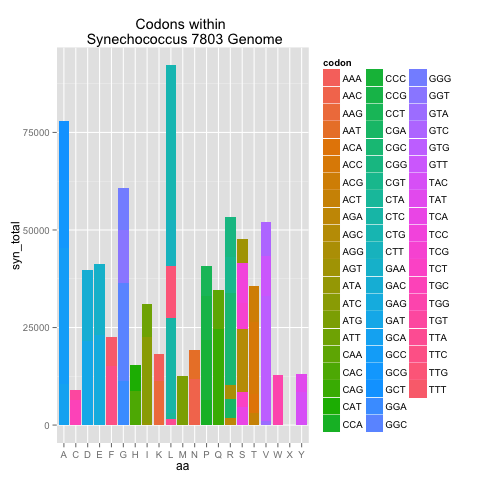

In [7]:
%%R
syn_w<-read.table("./data/svm1/Syn7803.w", header=TRUE, sep="\t", na.strings="*****")
codonm<-"./data/svm1/Syn7803.cds.m"%>%scan%>%matrix(ncol=61, byrow=T)
rownames(codonm)<-syn_w$title
ccn<-read.table("./scripts/codonR/codonm_colnames.txt", sep="\t")
colnames(codonm)<-ccn$V2


codon_totals<-data.frame(colSums(codonm))
codon_totals$codon<-rownames(codon_totals)
colnames(codon_totals)[1]<-"SynTotal"
head(codon_totals)

ac_table<-read.table("anti_codon_table.txt", header=TRUE, sep="\t")
ac_codons<-filter(ac_table, exact==1)
ac_codons$syn_total<-codon_totals$SynTotal[match(ac_codons$codon, codon_totals$codon)]
ac_codons%>%group_by(aa)%>%summarise(total_aa_codons=sum(syn_total))->aa_summary

ggplot(ac_codons, aes(aa, syn_total, fill=codon))+geom_bar(stat="identity")+guides(fill=guide_legend(ncol=3))->Gcodonplot
Gcodonplot+labs(title="Codons within \n Synechococcus 7803 Genome")->Gcodonplot
plot(Gcodonplot)

codon_prop<-vector()
for (i in seq(1:nrow(ac_codons))){
    a=ac_codons[i,3]
    n=ac_codons[i,5]
    
    total=aa_summary$total_aa_codons[which(a==aa_summary$aa)]
    codon_prop=c(codon_prop, n/total)
    }
ac_codons<-cbind.data.frame(ac_codons, codon_prop)

###Look through tRNA content and select phages with unique tRNA profiles

codons<-read.table("./data/codon_list.txt", header=FALSE)
colnames(codons)[2]<-"V6"

trna<-read.table("./data/svm1/Syn7803.trna", skip=3, header=FALSE,sep="\t")
trna%>%group_by(V6)%>%summarise(count=n())->trna
colnames(trna)[2]<-"Syn7803_trnas"
codons<-merge(codons, trna, by="V6", all.x=TRUE, all.y=TRUE)

for (phage in s7803p){
    trna<-read.table(paste("./data/pgenomes/Syn7803phages/", phage, ".trna",sep=""), skip=3, header=FALSE,sep="\t")
    trna%>%group_by(V6)%>%summarise(count=n())->trna
    colnames(trna)[2]<-phage
    codons<-merge(codons, trna, by="V6", all.x=TRUE, all.y=TRUE)
}

codons$V1<-NULL
codons[is.na(codons)]<-0
rownames(codons)<-codons$V6
codons$V6<-NULL

members<-t(as.matrix(codons))

utp<-data.frame(t(unique(members)))
utp$codon<-rownames(utp)

syn_codon<-merge(ac_codons, utp, by="codon", all.x=TRUE)
phage_trna_total=vector()
for (i in seq(1:nrow(syn_codon))){
    total_phage_trnas=sum(syn_codon[i,8:ncol(syn_codon)])
    phage_trna_total=c(phage_trna_total, total_phage_trnas)
    }

syn_codon<-cbind.data.frame(syn_codon, phage_trna_total)

#looking at a summary of tRNAs encoded by phages of Syn 7803
print("Here's a summary of the codons targeted by various phage tRNAs:")
syn_codon[syn_codon$phage_trna_total>0,c(1,3,6,7,ncol(syn_codon))]%>%print

Using codon as id variables


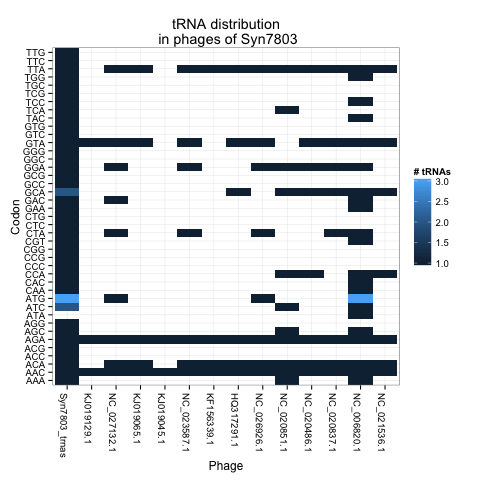

In [31]:
%%R
head(syn_codon)

syn_codon[,c(1,7:20)]%>%melt%>%filter(value>0)%>%ggplot(aes(variable, codon))+geom_tile(aes(fill=as.integer(value)))+theme_bw()->fig
fig+labs(title="tRNA distribution\n in phages of Syn7803", x="Phage",y="Codon", fill="# tRNAs")+theme(axis.text.x=element_text(angle = -90, hjust = 0))->fig
plot(fig)

#+scale_colour_gradient(limits=c(1,3))

Based on the above table, it looks like for Synechococcus the tRNAs encoded by phages add redundancy to tRNAs already utilized by Synechococcus.  The codon usage of these tRNAs is variable, but generally, they are under-represented codons within the host genome relative to other synonymous tRNAs.  The next step will be to ID genes where these codons are over represented relative to the genome average for the amino acid they encode.

It's worth noting that nearly all amino acids (18 out of 20) are represented by this set of codons.

In [28]:
%%R
#putting together code to score gene based on its phage codons
#preliminarily I'm going to use all codons selected by at least one phage tRNA within this dataset:
codonlist<-syn_codon[syn_codon$phage_trna_total>0,1]

codon_prop=vector()
gene<-data.frame(codonm[1,])

gptr<-function(codonlist, gene){
        anti<-read.table("anti_codon_table.txt", header=TRUE, sep="\t")%>%filter(exact==1)
        gene$codon<-rownames(gene)
        colnames(gene)[1]<-"count"
        merge(anti, gene, by="codon")->gene
        gene%>%filter(exact==1)%>%group_by(aa)%>%summarise(aa_count=sum(count))->aa_sum

        for (codon in codonlist){
        a=gene$aa[which(codon==gene$codon)]
        n=gene$count[which(codon==gene$codon)]     #the number of exact match codons in the gene
        total=aa_sum$aa_count[which(a==aa_sum$aa)] #the total number of codons for the specific amino acid
        codon_prop=c(codon_prop, n/total)
        }
        return(cbind.data.frame(codonlist, codon_prop))
        }
#test:
gptr(codonlist, gene)

   codonlist codon_prop
1        AAA 0.50000000
2        AAC 0.66666667
3        ACA 0.04000000
4        AGA 0.00000000
5        AGC 0.45000000
6        ATA 0.00000000
7        ATC 0.40000000
8        ATG 1.00000000
9        CAA 0.11764706
10       CAC 0.75000000
11       CCA 0.05000000
12       CGT 0.44000000
13       CTA 0.02000000
14       GAA 0.33333333
15       GAC 0.27586207
16       GCA 0.11111111
17       GGA 0.12500000
18       GTA 0.03030303
19       TAC 0.40000000
20       TCA 0.05000000
21       TCC 0.22500000
22       TGG 1.00000000
23       TTA 0.00000000


In [27]:
%%R

codonlist<-syn_codon[syn_codon$phage_trna_total>0,1]

#Calculate representation of phage-trna targeted codons within the host genome (based on codonm file)
Gptr<-function(codonlist, codonm){
    anti<-read.table("anti_codon_table.txt", header=TRUE, sep="\t")%>%filter(exact==1)
    genome_codon_prop=vector()
    genome<-data.frame(colSums(codonm))
    genome$codon<-rownames(genome)
    colnames(genome)[1]<-"count"

    merge(anti, genome, by="codon")->genome

    genome%>%group_by(aa)%>%summarise(aa_count=sum(count))->genome_aa_sum

    for (codon in codonlist){
        a=genome$aa[which(codon==genome$codon)]
        n=genome$count[which(codon==genome$codon)]     #the number of exact match codons in the gene
        total=genome_aa_sum$aa_count[which(a==genome_aa_sum$aa)] #the total number of codons for the specific amino acid
        genome_codon_prop=c(genome_codon_prop, n/total)
        }
        output<-cbind.data.frame(codonlist, genome_codon_prop)
        return(output)
        }
#test:
Genome_rep<-Gptr(codonlist, codonm)

Put these two together to calculate the mean phage-tRNA targeted codon representation (ptcs) for each gene.

In [11]:
%%R
#look at the phage tRNA codon score for each gene in the host genome:
gene_ptcs<-vector()
Genome_rep<-Gptr(codonlist, codonm)

for (i in seq(1:nrow(codonm))){
    Gene_rep<-gptr(codonlist, data.frame(codonm[i,]))
    Together<-merge(Genome_rep, Gene_rep, by="codonlist")%>%mutate(pig=codon_prop/genome_codon_prop)
    ptcs<-mean(Together$pig)
    gene_ptcs<-c(gene_ptcs, ptcs)
}

##Results of this analysis:

[1] "the number of genes with a ptcs greater than three are: 26"
[1] "the number of genes with a ptcs greater than two are: 66"


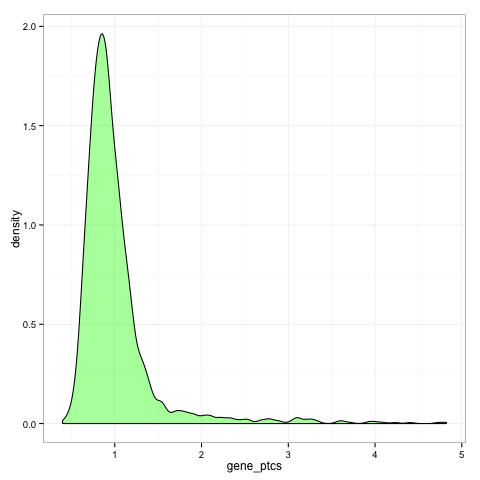

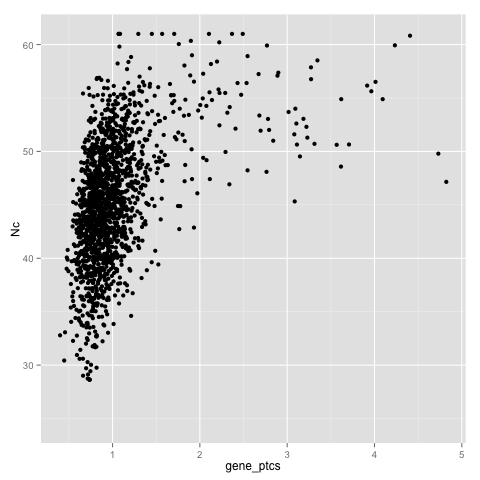

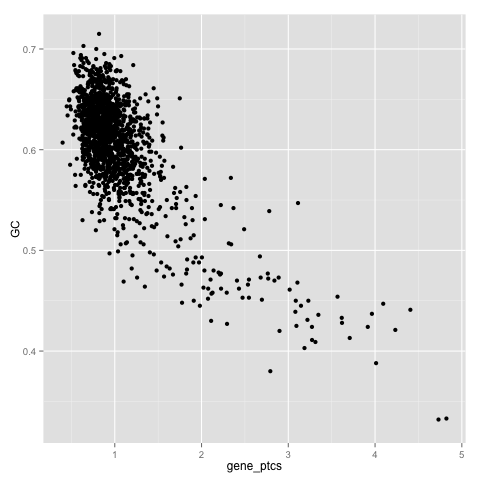

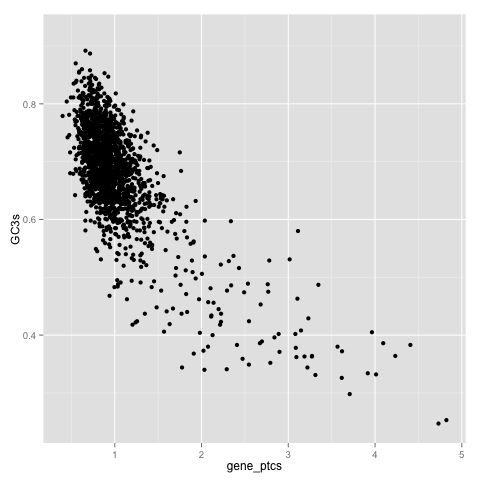

In [12]:
%%R
#Results:
syn_w<-read.table("./data/svm1/Syn7803.w", header=TRUE, sep="\t", na.strings="*****")
syn_w$X<-NULL
cbind.data.frame(syn_w, gene_ptcs)->syn_w
print(paste("the number of genes with a ptcs greater than three are:", nrow(syn_w[which(syn_w$gene_ptcs>3),])))
print(paste("the number of genes with a ptcs greater than two are:", nrow(syn_w[which(syn_w$gene_ptcs>2),])))

#plots
ggplot(data.frame(gene_ptcs), aes(gene_ptcs))+geom_density(alpha=0.4, fill="green")+theme_bw()->f
plot(f)
ggplot(syn_w, aes(gene_ptcs, Nc))+geom_point()->l
plot(l)
ggplot(syn_w, aes(gene_ptcs,GC))+geom_point()->k
plot(k)
ggplot(syn_w, aes(gene_ptcs,GC3s))+geom_point()->j
plot(j)

This is cool!  It shows that for the distribution of phage-tRNA targeted codons throughout the genome is generally normal (centered around [perhaps slightly below] the genome average frequency), but there is a tail of genes in which these codons are over-represented.  When comparing ptcs to Nc value (aka codon diversity within a gene), there appears to be a positive relationship, and when comparing to GC and GC3 content, there appears to be a negative relationship (higher ptcs=lower GC and GC3 content).

In [13]:
%%R
gene_order<-seq(1:nrow(syn_w))
syn_w<-cbind.data.frame(gene_order, syn_w)

annotations<-read.csv("Syn7803_CDS_table.txt", header=TRUE, sep="\t")
syn_w$title<-gsub(" ","",syn_w$title)
annotations$title<-gsub(" ","",annotations$title)
syn_w<-merge(syn_w, annotations, by="title", all.x=TRUE)

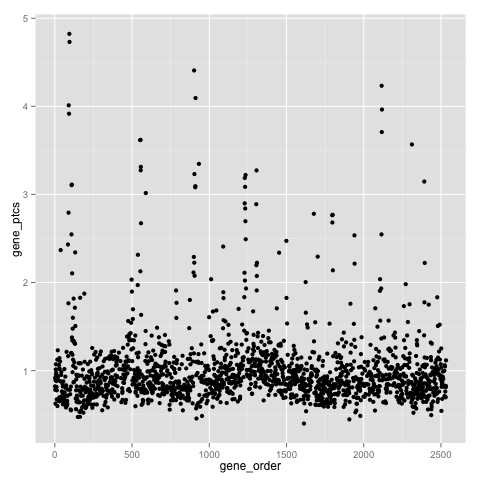

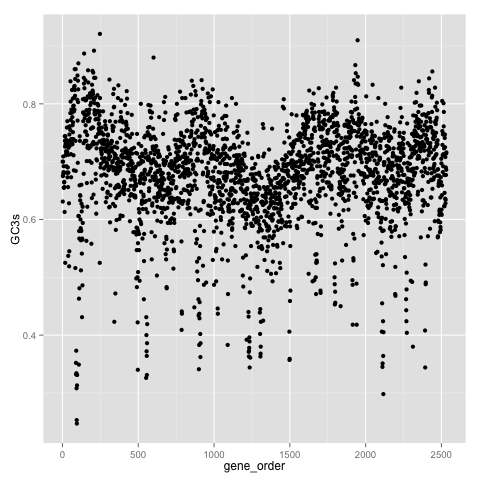

In [14]:
%%R
#Where do high pcts scoring genes fall in the genome?
ggplot(syn_w, aes(gene_order, gene_ptcs))+geom_point()->b
plot(b)
ggplot(syn_w, aes(gene_order, GC3s))+geom_point()->bb
plot(bb)

ptcs tracks low GC genes, but is less noisy.

Finally, what are these genes, exactly?

In [20]:
%%R
library(parody)
outliers<-calout.detect(na.omit(syn_w$gene_ptcs), alpha=0.01, method="boxplot")
syn_w[outliers$ind,]%>%print
print(length(outliers$ind))

              title gene_order    Nc  GC3s    GC L_aa gene_ptcs
29   SynWH7803_0029         29 32.01 0.759 0.593  341 0.6962226
61   SynWH7803_0061         61 43.61 0.734 0.645  444 0.6794226
64   SynWH7803_0064         64 32.35 0.785 0.625  451 0.7157876
65   SynWH7803_0065         65 42.77 0.777 0.636  292       NaN
66   SynWH7803_0066         66 45.52 0.730 0.622  294 0.6594615
67   SynWH7803_0067         67 38.23 0.763 0.673  540 0.6349056
68   SynWH7803_0068         68 39.52 0.809 0.668  413 0.9317503
76   SynWH7803_0076         76 34.61 0.787 0.684  350 1.2129205
77   SynWH7803_0077         77 33.20 0.829 0.699  258       NaN
78   SynWH7803_0078         78 43.65 0.811 0.648  128       NaN
80   SynWH7803_0080         80 34.64 0.831 0.620  678 0.6580370
97   SynWH7803_0097         97 48.83 0.331 0.379  240       NaN
343  SynWH7803_0343        343 45.12 0.714 0.642  193 0.5820905
371  SynWH7803_0371        371 48.06 0.692 0.622  943 0.9215203
372  SynWH7803_0372        372 46.74 0.6

Looks like some of the same characters from the tAI multivariate analysis.  Good to see!  Hypotheticals, transporters and membrane associated proteins mostly.  Interesting that a couple of different sugar-associated proteins also appear.

Finally, to compare these two analyses, I could plot the ptcs values against the PCA1 coordinates to see how they line up:

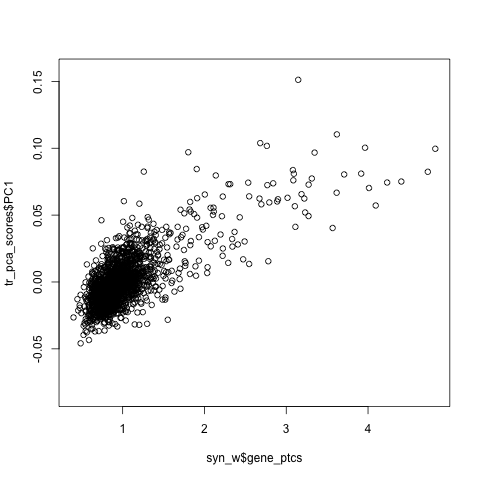

In [129]:
%%R
plot(syn_w$gene_ptcs, tr_pca_scores$PC1)

ptcs does a better job separating out selected genes, but to really compare these two methods I should either compute ptcs for each tRNA combination and then employ the same multivariate approach to compare gene scores across phages, or use the combined tRNA profile for calculation of tAI values.  I'll get into such issues next.

Note: Both these methods have different underlying assumptions that may or not be exactly correct biologically that we must consider; but the assumptions are different between methods.  

Another note: In both of the methods above, I combined tRNA information from several different phages rather than looking at the influences of individual phages...One phage could be swaying the results in a particular direction.

In [35]:
%%R
#going through the codons from most to least abundant within phage genomes:
syn_codon[order(-syn_codon$phage_trna_total),]%>%.$phage_trna_total%>%unique->tabund
print(tabund)

combo<-data.frame(gene_order=integer(),title=character(),Nc=integer(),GC3s=integer(),GC=integer(),L_aa=integer(),gene_ptcs=integer(),product=character(),num_trnas=factor())

for (number in tabund){
    codonlist<-syn_codon[syn_codon$phage_trna_total>=number,1]
    print(codonlist)
    
    gene_ptcs<-vector()
    Genome_rep<-Gptr(codonlist, codonm)

for (i in seq(1:nrow(codonm))){
    Gene_rep<-gptr(codonlist, data.frame(codonm[i,]))
    Together<-merge(Genome_rep, Gene_rep, by="codonlist")%>%mutate(pig=codon_prop/genome_codon_prop)
    ptcs<-mean(Together$pig)
    gene_ptcs<-c(gene_ptcs, ptcs)
}
    host_w<-read.table(paste("./data/svm1/Syn7803.w", sep=""), header=TRUE, sep="\t", na.strings="*****")
    host_w$X<-NULL
    cbind.data.frame(host_w, gene_ptcs)->host_w
    gene_order<-seq(1:nrow(host_w))
    host_w<-cbind.data.frame(gene_order, host_w)
    annotations<-read.csv(paste("./Syn7803_CDS_table.txt",sep=""), header=TRUE, sep="\t")
    host_w$title<-gsub(" ","",host_w$title)
    annotations$title<-gsub(" ","",annotations$title)
    host_w$product<-annotations$product[match(host_w$title, annotations$title)]
    host_w$total_frequency<-number
    combo<-rbind(host_w, combo)
}

#codonlist<-syn_codon[syn_codon$phage_trna_total>0,1]

 [1] 13 11 10  7  6  5  4  2  1  0
[1] AAC AGA
64 Levels: AAA AAC AAG AAT ACA ACC ACG ACT AGA AGC AGG AGT ATA ATC ATG ... TTT
[1] AAC ACA AGA TTA
64 Levels: AAA AAC AAG AAT ACA ACC ACG ACT AGA AGC AGG AGT ATA ATC ATG ... TTT
[1] AAC ACA AGA GTA TTA
64 Levels: AAA AAC AAG AAT ACA ACC ACG ACT AGA AGC AGG AGT ATA ATC ATG ... TTT
[1] AAC ACA AGA GGA GTA TTA
64 Levels: AAA AAC AAG AAT ACA ACC ACG ACT AGA AGC AGG AGT ATA ATC ATG ... TTT
[1] AAC ACA AGA GCA GGA GTA TTA
64 Levels: AAA AAC AAG AAT ACA ACC ACG ACT AGA AGC AGG AGT ATA ATC ATG ... TTT
[1] AAC ACA AGA ATG CTA GCA GGA GTA TTA
64 Levels: AAA AAC AAG AAT ACA ACC ACG ACT AGA AGC AGG AGT ATA ATC ATG ... TTT
 [1] AAC ACA AGA ATG CCA CTA GCA GGA GTA TTA
64 Levels: AAA AAC AAG AAT ACA ACC ACG ACT AGA AGC AGG AGT ATA ATC ATG ... TTT
 [1] AAA AAC ACA AGA AGC ATC ATG CCA CTA GAC GCA GGA GTA TTA
64 Levels: AAA AAC AAG AAT ACA ACC ACG ACT AGA AGC AGG AGT ATA ATC ATG ... TTT
 [1] AAA AAC ACA AGA AGC ATA ATC ATG CAA CAC CCA CGT CTA GAA GAC GCA GG

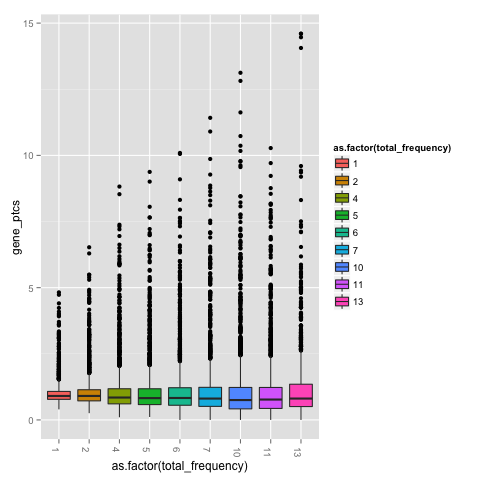

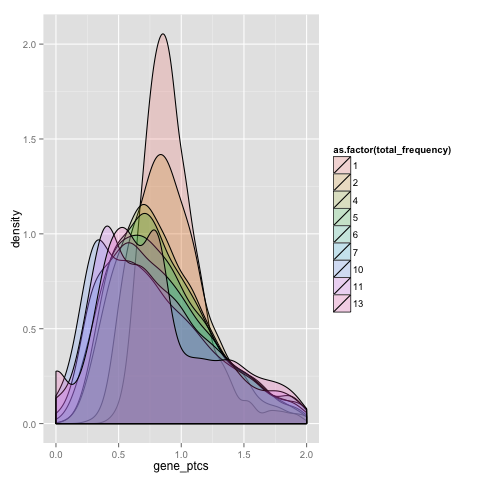

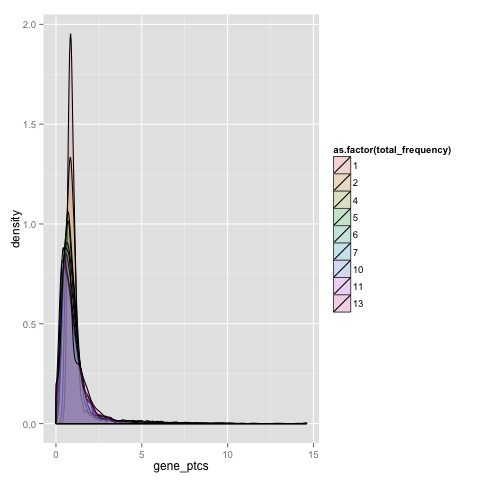

In [36]:
%%R
ggplot(na.omit(combo), aes(x=as.factor(total_frequency), y=gene_ptcs, fill=as.factor(total_frequency)))+geom_boxplot()->f
f<-f+theme(axis.text.x=element_text(angle = -90, hjust = 0))
plot(f)

ggplot(na.omit(combo), aes(gene_ptcs, fill=as.factor(total_frequency)))+geom_density(alpha=0.2)+xlim(c(0,2))->g
plot(g)

ggplot(na.omit(combo), aes(gene_ptcs, fill=as.factor(total_frequency)))+geom_density(alpha=0.2)->g1
plot(g1)

###ptcs of Syn7803 tRNAs on phage genes: